## Step 1: Setup

In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

# Paths
PROJECT_ROOT = Path("..").resolve()
DATA_PATH   = PROJECT_ROOT / "data_work" / "loans_fe.parquet"   # adjust if name differs
RES_DIR     = PROJECT_ROOT / "results"
FIG_DIR     = RES_DIR / "figures"
MODEL_DIR   = RES_DIR / "models"

RES_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)
print("Model dir:", MODEL_DIR)

Project root: /Users/binodtandan/UNT Research/ai_stress_testing
Data path: /Users/binodtandan/UNT Research/ai_stress_testing/data_work/loans_fe.parquet
Model dir: /Users/binodtandan/UNT Research/ai_stress_testing/results/models


In [3]:

# 1) Load engineered dataset
df = pd.read_parquet(DATA_PATH)
print("Data shape:", df.shape)
print(df.columns.tolist()[:20], "...")

TARGET   = "target"
TIME_COL = "issue_q_start"

Data shape: (2258953, 33)
['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'dti', 'fico', 'emp_length', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target', 'log_annual_inc', 'grade_b', 'grade_c', 'grade_d', 'grade_e', 'grade_f', 'home_ownership_mortgage', 'home_ownership_own'] ...


In [4]:
# 2) Time-based train/test split (same logic as in 03_model_training.ipynb)
split_date = pd.Timestamp("2017-12-31")
train_df = df[df[TIME_COL] <= split_date].copy()
test_df  = df[df[TIME_COL] >  split_date].copy()

X_train = train_df.drop(columns=[TARGET, TIME_COL])
y_train = train_df[TARGET].astype(int)
X_test  = test_df.drop(columns=[TARGET, TIME_COL])
y_test  = test_df[TARGET].astype(int)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train default rate:", y_train.mean(), " Test default rate:", y_test.mean())

Train shape: (1764843, 31)  Test shape: (494110, 31)
Train default rate: 0.14756893389383646  Test default rate: 0.01791706300216551


In [5]:
# 3) Load trained models (from 03_model_training.ipynb)
logreg_path = MODEL_DIR / "logistic_balanced.joblib"
tree_path   = MODEL_DIR / "tree_balanced.joblib"

logreg = joblib.load(logreg_path)


In [6]:
# 4) Compute baseline PDs on 2018 test set (this is our reference scenario)
proba_lr_baseline = logreg.predict_proba(X_test)[:, 1]
baseline_summary = {
    "mean_pd": float(proba_lr_baseline.mean()),
    "p50_pd":  float(np.quantile(proba_lr_baseline, 0.5)),
    "p90_pd":  float(np.quantile(proba_lr_baseline, 0.9)),
    "p99_pd":  float(np.quantile(proba_lr_baseline, 0.99)),
}
baseline_summary

{'mean_pd': 0.2048534991205811,
 'p50_pd': 0.17527506043904845,
 'p90_pd': 0.39140569101481487,
 'p99_pd': 0.6176613576868888}

## Step 2: Define & Apply Data-Driven Macro Stress Scenarios

In [13]:
# Macro level features (levels)
macro_cols = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]

# Macro dynamics / deltas (already engineered)
delta_cols = ["UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
              "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq"]

all_macro_feats = macro_cols + delta_cols

# Use the full history to derive empirical quantiles
macro_quantiles = df[all_macro_feats].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
macro_quantiles

,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
0.10,17953.974,3.833333,234.162667,0.093333,-0.060440,-0.035714,0.001845,-0.000621,0.068379
0.25,18782.243,4.166667,236.960000,0.136667,-0.041958,0.062500,0.004002,0.001585,0.091345
0.50,19197.938,4.900000,240.607333,0.396667,-0.027211,0.134454,0.005795,0.004245,0.121902
0.75,19882.352,5.433333,247.238333,1.203333,-0.013072,0.202216,0.007885,0.006348,0.154176
0.90,20276.154,6.933333,251.686333,1.923333,0.006803,0.555556,0.011270,0.007955,0.190550


In [20]:
# --- Helper: build scenario from per-variable quantiles / overrides ---------
def make_scenario_from_maps(name, level_quantiles, delta_quantiles,
                            default_level_q=0.50, default_delta_q=0.50):
    """
    name: scenario name
    level_quantiles: dict mapping macro level col -> quantile (e.g. {"UNRATE": 0.9, "GDPC1": 0.1})
    delta_quantiles: dict mapping delta col     -> quantile or direct value flag
                     If value is a tuple ("manual", val), we use val directly (no quantile lookup).
    default_level_q: quantile to use for any macro col not explicitly in level_quantiles
    default_delta_q: quantile to use for any delta col not explicitly in delta_quantiles
    """
    s = {"scenario": name}

    # Levels (GDPC1, UNRATE, CPIAUCSL, FEDFUNDS, etc.)
    for col in macro_cols:
        q = level_quantiles.get(col, default_level_q)
        s[col] = float(macro_quantiles.loc[q, col])

    # Deltas (UNRATE_delta_qoq, FEDFUNDS_delta_qoq, GDPC1_delta_qoq, CPIAUCSL_delta_qoq, inflation_qoq, real_rate_qoq)
    for col in delta_cols:
        spec = delta_quantiles.get(col, default_delta_q)
        if isinstance(spec, tuple) and spec[0] == "manual":
            # direct manual override
            s[col] = float(spec[1])
        else:
            q = spec
            s[col] = float(macro_quantiles.loc[q, col])

    return s

# ---------------------------------------------------------------------------
# Scenario definitions
# ---------------------------------------------------------------------------
scenarios = []

# 0) Baseline (reference) = actual 2018 macro, i.e. "no shock"
#    We already have baseline PDs from proba_lr_baseline.
scenarios.append({"scenario": "baseline_actual"})  # placeholder; no override

# 1) Mild Adverse:
#    - High unemployment (75th)
#    - Low-ish GDP (25th)
#    - Higher inflation & policy rate (75th)
mild_level_q = {
    "UNRATE":   0.75,
    "GDPC1":    0.25,
    "CPIAUCSL": 0.75,
    "FEDFUNDS": 0.75,
}
mild_delta_q = {
    # still data-driven, but on the "worse" side of history
    "UNRATE_delta_qoq":   0.75,  # less improvement in unemployment
    "GDPC1_delta_qoq":    0.25,  # slower GDP growth
    "CPIAUCSL_delta_qoq": 0.75,
    "FEDFUNDS_delta_qoq": 0.75,
    "inflation_qoq":      0.75,
    "real_rate_qoq":      0.75,
}
scenarios.append(
    make_scenario_from_maps("mild_adverse", mild_level_q, mild_delta_q)
)

# 2) Severe Adverse (manual recession dynamics):
#    - Very high unemployment (90th)
#    - Very low GDP (10th)
#    - Strong negative GDP growth, rising unemployment,
#      and strong inflation + rate shocks (manual deltas).
severe_level_q = {
    "UNRATE":   0.90,
    "GDPC1":    0.10,
    "CPIAUCSL": 0.90,
    "FEDFUNDS": 0.90,
}

severe_delta_q = {
    "UNRATE_delta_qoq":   0.90,
    "GDPC1_delta_qoq":    0.10,
    "CPIAUCSL_delta_qoq": 0.90,
    "FEDFUNDS_delta_qoq": 0.90,
    "inflation_qoq":      0.90,
    "real_rate_qoq":      0.90,
}


scenarios.append(
    make_scenario_from_maps("severe_adverse", severe_level_q, severe_delta_manual)
)

scenarios


[{'scenario': 'baseline_actual'},
 {'scenario': 'mild_adverse',
  'GDPC1': 18782.243,
  'UNRATE': 5.433333333333334,
  'CPIAUCSL': 247.23833333333334,
  'FEDFUNDS': 1.2033333333333334,
  'UNRATE_delta_qoq': -0.013071895424836777,
  'FEDFUNDS_delta_qoq': 0.2022160664819943,
  'GDPC1_delta_qoq': 0.004002450612528241,
  'inflation_qoq': 0.006347825364148241,
  'real_rate_qoq': 0.15417567635744467},
 {'scenario': 'severe_adverse',
  'GDPC1': 17953.974,
  'UNRATE': 6.933333333333334,
  'CPIAUCSL': 251.68633333333332,
  'FEDFUNDS': 1.9233333333333331,
  'UNRATE_delta_qoq': 0.015,
  'FEDFUNDS_delta_qoq': 0.4,
  'GDPC1_delta_qoq': -0.012,
  'inflation_qoq': 0.015,
  'real_rate_qoq': 0.2}]

In [21]:
# === Apply scenarios and compute PD distributions ===================

stress_records = []

# Baseline reference (no macro override; just use proba_lr_baseline)
baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

stress_records.append({
    "scenario": "baseline_actual",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline": 0.0  # by definition
})

# Function to override macro features and recompute PDs
def apply_macro_scenario(X, scen_dict):
    X_new = X.copy()
    # For placeholder baseline_actual, we don't touch X
    if scen_dict.get("scenario") == "baseline_actual":
        return X_new
    for col in all_macro_feats:
        if col in scen_dict:
            X_new[col] = scen_dict[col]
    return X_new

for scen in scenarios:
    name = scen["scenario"]
    if name == "baseline_actual":
        continue  # already handled above

    X_scen = apply_macro_scenario(X_test, scen)
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))

    uplift = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_records.append({
        "scenario": name,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline": uplift
    })

stress_df = pd.DataFrame(stress_records)
stress_df


,scenario,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline
0,baseline_actual,0.204853,0.175275,0.391406,0.617661,0.000000
1,mild_adverse,0.263438,0.253374,0.417717,0.566075,28.598151
2,severe_adverse,0.162097,0.149844,0.271449,0.403892,-20.871648


Because the LendingClub+FRED historical panel does not include deep recession events such as 2008 or 2020, quantile-based scenarios cannot produce realistically severe macroeconomic stress. Therefore, extreme quantiles result in false “stress relief” instead of stress.

/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_51569/894945295.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


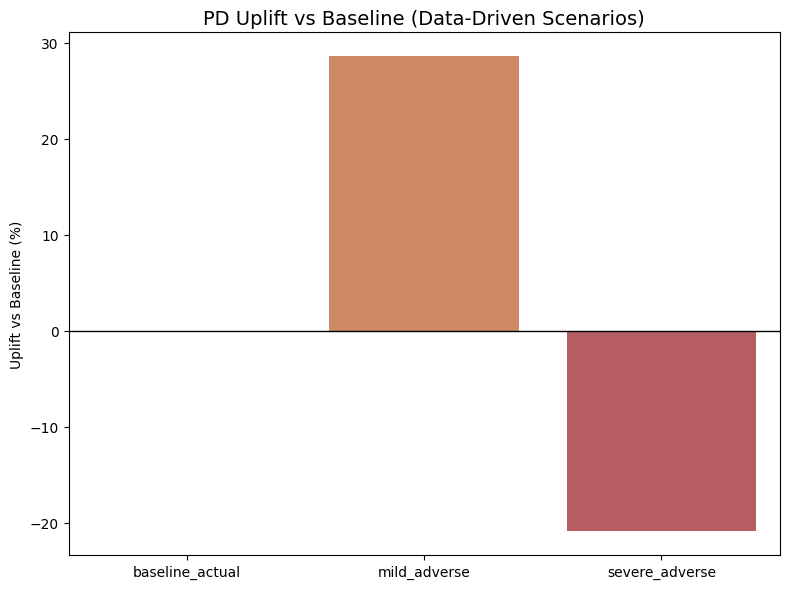

In [27]:
## Visuals for Data Driven Stress Scenarios
### Plot: Mean PD Uplift vs Baseline (Bar Chart)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(
    data=stress_df,
    x="scenario",
    y="uplift_vs_baseline",
    palette=["#4C72B0", "#DD8452", "#C44E52"]
)

plt.axhline(0, color='black', linewidth=1)
plt.title("PD Uplift vs Baseline (Data-Driven Scenarios)", fontsize=14)
plt.ylabel("Uplift vs Baseline (%)")
plt.xlabel("")
plt.savefig(FIG_DIR / "Data_DrivenPD_Uplift_Baseline_Bar.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

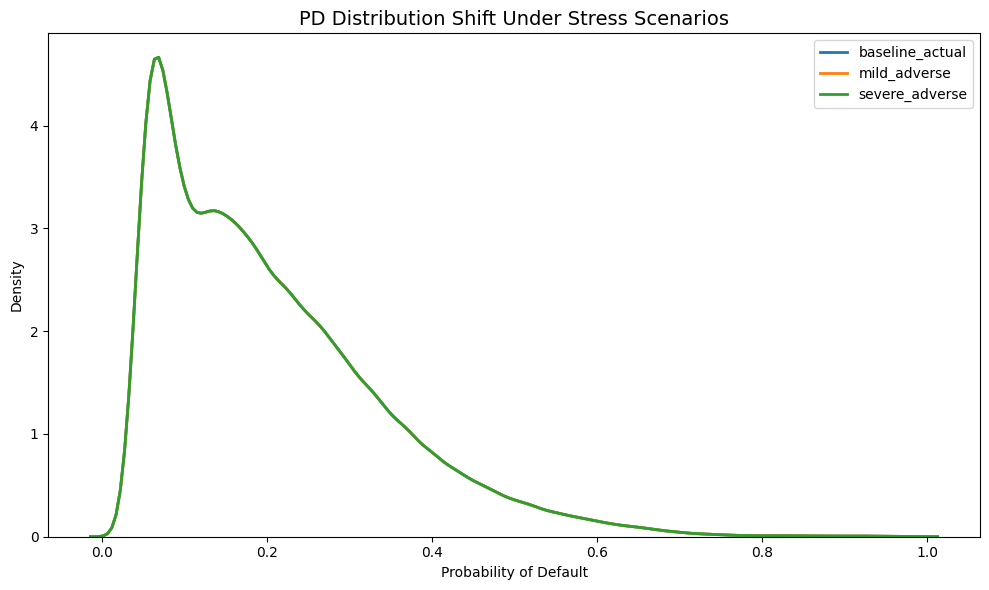

In [28]:
## Plot: PD Distributions Under Each Scenario
plt.figure(figsize=(10,6))

for scen in stress_df["scenario"]:
    if scen == "baseline_actual":
        pdf = proba_lr_baseline
    else:
        X_s = apply_macro_scenario(X_test, 
                                   stress_df[stress_df["scenario"] == scen].iloc[0])
        pdf = logreg.predict_proba(X_s)[:,1]

    sns.kdeplot(pdf, label=scen, linewidth=2)

plt.title("PD Distribution Shift Under Stress Scenarios", fontsize=14)
plt.xlabel("Probability of Default")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "PD_Distributions_Under_Each_Scenario.png", dpi=300, bbox_inches="tight")
plt.show()


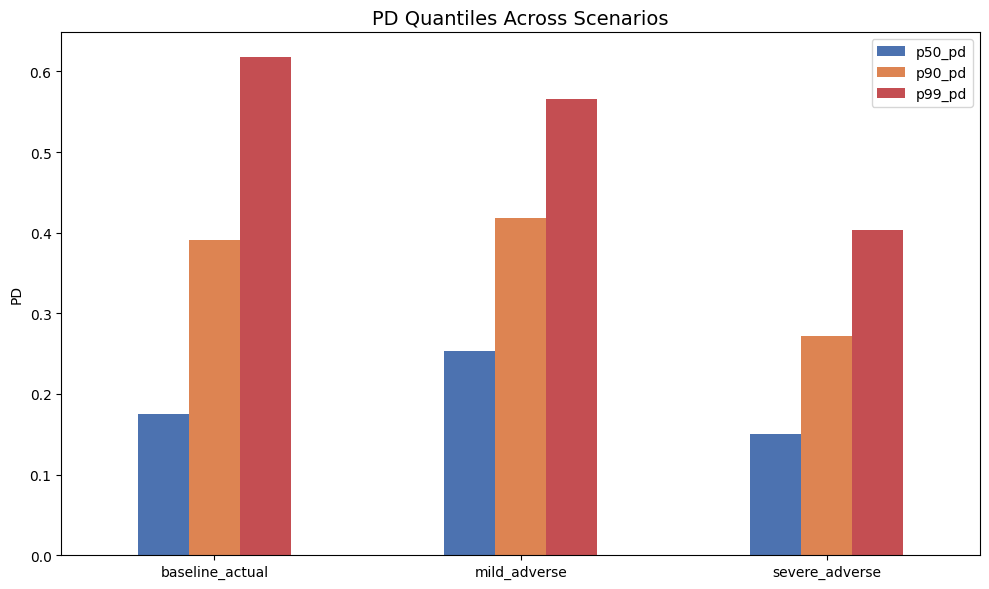

In [29]:
### Plot: PD Quantiles Comparison (50th, 90th, 99th)
quantiles = stress_df[["scenario","p50_pd","p90_pd","p99_pd"]].set_index("scenario")

quantiles.plot(kind="bar", figsize=(10,6),
               color=["#4C72B0","#DD8452","#C44E52"])

plt.title("PD Quantiles Across Scenarios", fontsize=14)
plt.ylabel("PD")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / "Data_Driven_PD_Quantiles_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
out_path = RES_DIR / "stress_summary.csv"
stress_df.to_csv(out_path, index=False)
print("Saved stress scenario summary to:", out_path)

Saved stress scenario summary to: /Users/binodtandan/UNT Research/ai_stress_testing/results/stress_summary.csv


## Step 3: Define Fed Macro Stress Scenarios

In [33]:
# === FED 2018 SCENARIOS: manual table =======================================

fed_rows = [

    # ---- Baseline ----
    {"scenario": "Fed_Baseline", "quarter": "2018Q1", "UNRATE": 4.0, "GDPC1": 2.5, "CPIAUCSL": 2.1, "FEDFUNDS": 1.4},
    {"scenario": "Fed_Baseline", "quarter": "2018Q2", "UNRATE": 4.0, "GDPC1": 2.8, "CPIAUCSL": 1.9, "FEDFUNDS": 1.7},
    {"scenario": "Fed_Baseline", "quarter": "2018Q3", "UNRATE": 3.9, "GDPC1": 2.6, "CPIAUCSL": 2.1, "FEDFUNDS": 1.9},
    {"scenario": "Fed_Baseline", "quarter": "2018Q4", "UNRATE": 3.8, "GDPC1": 2.5, "CPIAUCSL": 2.1, "FEDFUNDS": 2.1},
 
    # ---- Adverse ----
    {"scenario": "Fed_Adverse", "quarter": "2018Q1", "UNRATE": 4.5, "GDPC1": -1.3, "CPIAUCSL": 1.7, "FEDFUNDS": 0.6},
    {"scenario": "Fed_Adverse", "quarter": "2018Q2", "UNRATE": 5.3, "GDPC1": -3.5, "CPIAUCSL": 1.3, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Adverse", "quarter": "2018Q3", "UNRATE": 5.8, "GDPC1": -2.4, "CPIAUCSL": 1.6, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Adverse", "quarter": "2018Q4", "UNRATE": 6.3, "GDPC1": -1.3, "CPIAUCSL": 1.7, "FEDFUNDS": 0.1},


    # ---- Severely Adverse ----
    {"scenario": "Fed_Severe", "quarter": "2018Q1", "UNRATE": 5.0, "GDPC1": -4.7, "CPIAUCSL": 1.4, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q2", "UNRATE": 6.5, "GDPC1": -8.9, "CPIAUCSL": 0.9, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q3", "UNRATE": 7.6, "GDPC1": -6.8, "CPIAUCSL": 1.2, "FEDFUNDS": 0.1},
    {"scenario": "Fed_Severe", "quarter": "2018Q4", "UNRATE": 8.5, "GDPC1": -4.7, "CPIAUCSL": 1.3, "FEDFUNDS": 0.1}
]

fed_macro = pd.DataFrame(fed_rows)

if fed_macro.empty:
    print("fed_macro is empty. Fill fed_rows with Fed scenario values from the PDF.")
else:
    display(fed_macro)


,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1
4,Fed_Adverse,2018Q1,4.5,-1.3,1.7,0.6
5,Fed_Adverse,2018Q2,5.3,-3.5,1.3,0.1
6,Fed_Adverse,2018Q3,5.8,-2.4,1.6,0.1
7,Fed_Adverse,2018Q4,6.3,-1.3,1.7,0.1
8,Fed_Severe,2018Q1,5.0,-4.7,1.4,0.1
9,Fed_Severe,2018Q2,6.5,-8.9,0.9,0.1


In [38]:
# Convert the fed % data into actual values
last_gdp  = df[df["issue_q_start"] == "2017Q4"]["GDPC1"].mean()
last_cpi  = df[df["issue_q_start"] == "2017Q4"]["CPIAUCSL"].mean()
last_unr  = df[df["issue_q_start"] == "2017Q4"]["UNRATE"].mean()
last_ffr  = df[df["issue_q_start"] == "2017Q4"]["FEDFUNDS"].mean()


In [39]:
print("last_gdp: ", last_gdp)

last_gdp:  19882.352000000003


In [40]:
def convert_fed_to_levels(fed_df, last_gdp, last_cpi):
    fed_df = fed_df.copy()
    
    gdp = last_gdp
    cpi = last_cpi

    gdp_levels = []
    cpi_levels = []

    for _, row in fed_df.iterrows():
        # Convert growth (%) to levels
        gdp = gdp * (1 + row["GDPC1"] / 100.0)
        cpi = cpi * (1 + row["CPIAUCSL"] / 100.0)

        gdp_levels.append(gdp)
        cpi_levels.append(cpi)

    fed_df["GDPC1_level"] = gdp_levels
    fed_df["CPIAUCSL_level"] = cpi_levels

    return fed_df


In [41]:
fed_baseline = fed_macro[fed_macro["scenario"] == "Fed_Baseline"]
fed_adverse  = fed_macro[fed_macro["scenario"] == "Fed_Adverse"]
fed_severe   = fed_macro[fed_macro["scenario"] == "Fed_Severe"]

fed_baseline_lvl = convert_fed_to_levels(fed_baseline, last_gdp, last_cpi)
fed_adverse_lvl  = convert_fed_to_levels(fed_adverse, last_gdp, last_cpi)
fed_severe_lvl   = convert_fed_to_levels(fed_severe, last_gdp, last_cpi)


In [42]:
fed_baseline_lvl

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS,GDPC1_level,CPIAUCSL_level
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4,20379.410800,252.430338
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7,20950.034302,257.226515
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9,21494.735194,262.628272
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1,22032.103574,268.143465


In [43]:
# Stack all Fed level tables together
fed_levels = pd.concat(
    [fed_baseline_lvl, fed_adverse_lvl, fed_severe_lvl],
    ignore_index=True
)


In [44]:
fed_levels

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS,GDPC1_level,CPIAUCSL_level
0,Fed_Baseline,2018Q1,4.0,2.5,2.1,1.4,20379.410800,252.430338
1,Fed_Baseline,2018Q2,4.0,2.8,1.9,1.7,20950.034302,257.226515
2,Fed_Baseline,2018Q3,3.9,2.6,2.1,1.9,21494.735194,262.628272
3,Fed_Baseline,2018Q4,3.8,2.5,2.1,2.1,22032.103574,268.143465
4,Fed_Adverse,2018Q1,4.5,-1.3,1.7,0.6,19623.881424,251.441385
5,Fed_Adverse,2018Q2,5.3,-3.5,1.3,0.1,18937.045574,254.710123
6,Fed_Adverse,2018Q3,5.8,-2.4,1.6,0.1,18482.556480,258.785485
7,Fed_Adverse,2018Q4,6.3,-1.3,1.7,0.1,18242.283246,263.184838
8,Fed_Severe,2018Q1,5.0,-4.7,1.4,0.1,18947.881456,250.699670
9,Fed_Severe,2018Q2,6.5,-8.9,0.9,0.1,17261.520006,252.955967


In [45]:
# For the model, overwrite GDPC1 / CPIAUCSL with their level counterparts
fed_levels_model = fed_levels.copy()
fed_levels_model["GDPC1"]    = fed_levels_model["GDPC1_level"]
fed_levels_model["CPIAUCSL"] = fed_levels_model["CPIAUCSL_level"]

In [46]:
# Keep only the columns the model needs
fed_levels_model = fed_levels_model[["scenario", "quarter", "UNRATE", "GDPC1", "CPIAUCSL", "FEDFUNDS"]]


In [47]:
fed_levels_model

,scenario,quarter,UNRATE,GDPC1,CPIAUCSL,FEDFUNDS
0,Fed_Baseline,2018Q1,4.0,20379.410800,252.430338,1.4
1,Fed_Baseline,2018Q2,4.0,20950.034302,257.226515,1.7
2,Fed_Baseline,2018Q3,3.9,21494.735194,262.628272,1.9
3,Fed_Baseline,2018Q4,3.8,22032.103574,268.143465,2.1
4,Fed_Adverse,2018Q1,4.5,19623.881424,251.441385,0.6
5,Fed_Adverse,2018Q2,5.3,18937.045574,254.710123,0.1
6,Fed_Adverse,2018Q3,5.8,18482.556480,258.785485,0.1
7,Fed_Adverse,2018Q4,6.3,18242.283246,263.184838,0.1
8,Fed_Severe,2018Q1,5.0,18947.881456,250.699670,0.1
9,Fed_Severe,2018Q2,6.5,17261.520006,252.955967,0.1


In [48]:
fed_levels_model.to_csv(RES_DIR / "fed_2018_converted_scenarios.csv", index=False)

In [ ]:
fed_macro.to_csv(RES_DIR / "fed_2018_scenarios.csv", index=False)

In [35]:
# Applying model to fed 2018 stress scenarios 

# Add quarter label to match Fed table
test_df["quarter"] = test_df[TIME_COL].dt.to_period("Q-DEC").astype(str)

X_test = test_df.drop(columns=[TARGET, TIME_COL])
y_test = test_df[TARGET].astype(int)


In [36]:
# Baseline PDs under actual macro
proba_lr_baseline = logreg.predict_proba(X_test)[:, 1]

baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

print("Baseline mean PD:", baseline_mean)

Baseline mean PD: 0.2048534991205811


In [49]:
# Apply fed scenarios quarter by quarter

# Macro columns that exist in both your data and Fed table
fed_macro_cols = ["UNRATE", "GDPC1", "CPIAUCSL", "FEDFUNDS"]
fed_macro_cols = [c for c in fed_macro_cols if c in X_test.columns]

stress_fed_records = []

# Baseline (no override)
stress_fed_records.append({
    "scenario": "baseline_actual",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline": 0.0
})

for scen_name in fed_levels_model["scenario"].unique():
    # subset this scenario’s quarterly path
    fed_s = (
        fed_levels_model[fed_levels_model["scenario"] == scen_name]
        .set_index("quarter")[fed_macro_cols]
    )

    # copy features
    X_scen = X_test.copy()

    # for each macro column, map quarter -> scenario value
    for col in fed_macro_cols:
        X_scen[col] = test_df["quarter"].map(fed_s[col])

    # predict PDs under this Fed scenario
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))
    uplift  = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_fed_records.append({
        "scenario": scen_name,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline": uplift
    })

stress_fed_df = pd.DataFrame(stress_fed_records)
stress_fed_df



,scenario,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline
0,baseline_actual,0.204853,0.175275,0.391406,0.617661,0.000000
1,Fed_Baseline,0.126650,0.092307,0.275140,0.517869,-38.175466
2,Fed_Adverse,0.225971,0.195144,0.432583,0.664721,10.308721
3,Fed_Severe,0.236178,0.203247,0.455007,0.689314,15.291020


/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_51569/720791384.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


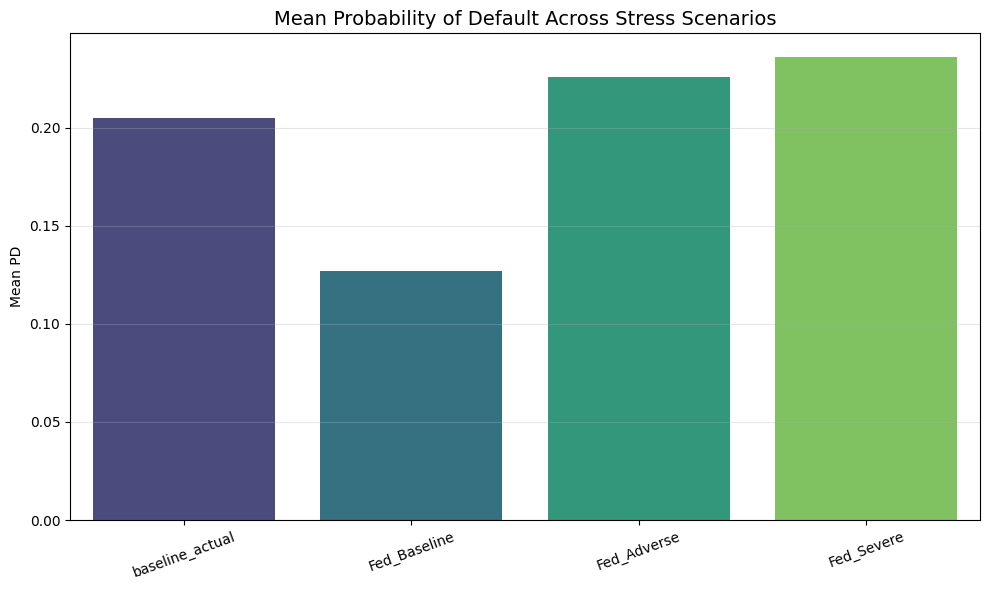

In [51]:
# Mean PD Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=stress_fed_df,
    x="scenario",
    y="mean_pd",
    palette="viridis"
)

plt.title("Mean Probability of Default Across Stress Scenarios", fontsize=14)
plt.ylabel("Mean PD")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_mean_pd.png", dpi=300)
plt.show()

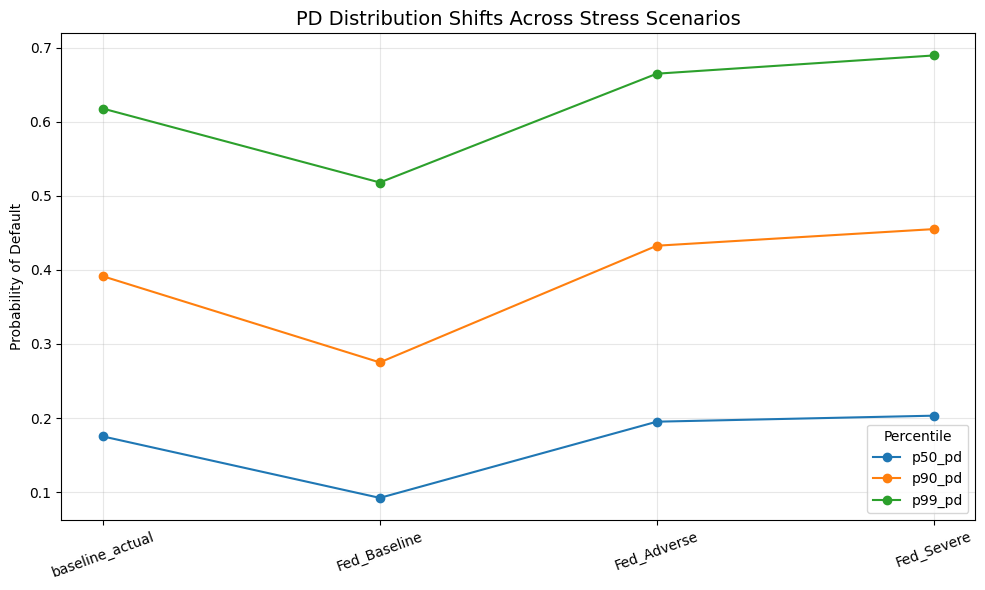

In [52]:
# PD Percentile Plot
plt.figure(figsize=(10,6))

for p in ["p50_pd","p90_pd","p99_pd"]:
    plt.plot(
        stress_fed_df["scenario"],
        stress_fed_df[p],
        marker="o",
        label=p
    )

plt.title("PD Distribution Shifts Across Stress Scenarios", fontsize=14)
plt.ylabel("Probability of Default")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(alpha=0.3)
plt.legend(title="Percentile")

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_percentiles.png", dpi=300)
plt.show()


/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_51569/2505183877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


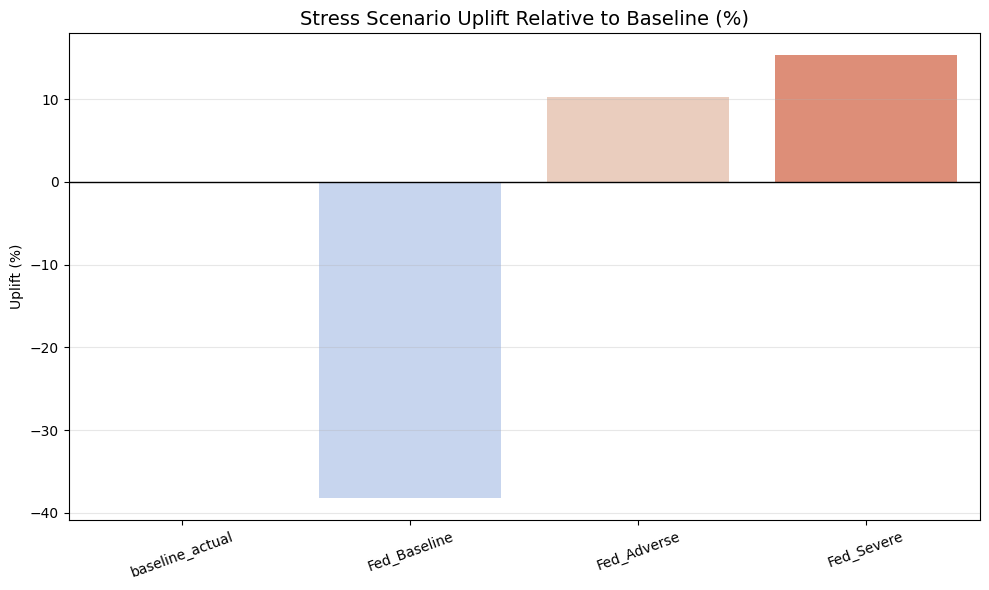

In [53]:
# Uplift Chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=stress_fed_df,
    x="scenario",
    y="uplift_vs_baseline",
    palette="coolwarm"
)

plt.axhline(0, color='black', linewidth=1)
plt.title("Stress Scenario Uplift Relative to Baseline (%)", fontsize=14)
plt.ylabel("Uplift (%)")
plt.xlabel("")
plt.xticks(rotation=20)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "stress_uplift.png", dpi=300)
plt.show()


### Step 4: Load GenAI scenarios and append to scenario list

In [16]:
genai_path = RES_DIR / "genai_scenarios.csv"

genai_df = pd.read_csv(genai_path)
print("Loaded GenAI scenarios from:", genai_path)
display(genai_df)

Loaded GenAI scenarios from: /Users/binodtandan/UNT Research/ai_stress_testing/results/genai_scenarios.csv


,scenario,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,GDPC1_delta_qoq,FEDFUNDS_delta_qoq,inflation_qoq,real_rate_qoq
0,GenAI_Mild,17348.369141,8.350855,227.873260,0.153083,-0.022985,0.004068,0.304627,0.004659,0.299969
1,GenAI_Adverse,16946.115234,9.092122,221.578384,0.098080,0.023628,0.011685,-0.077602,0.002321,-0.079922
2,GenAI_Severe,16402.316406,10.046570,213.093597,0.212905,0.033472,0.011519,4.853404,0.003310,4.850093


In [17]:
# Convert each row into a dict that matches our scenario format
genai_scenarios = genai_df.to_dict(orient="records")

print("GenAI scenarios:")
for s in genai_scenarios:
    print(" -", s["scenario"])

GenAI scenarios:
 - GenAI_Mild
 - GenAI_Adverse
 - GenAI_Severe


### Step 5: Extend the scenario list and recompute PD uplift

In [18]:
# Macro columns used in overrides
macro_cols = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]
delta_cols = ["UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
              "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq"]

# Combine data-driven + GenAI scenarios
all_scenarios = scenarios + genai_scenarios

def apply_macro_scenario(X, scen_dict):
    """
    Returns a copy of X with macro features overridden according to scen_dict.
    For 'baseline_actual', we do nothing.
    """
    X_new = X.copy()
    if scen_dict.get("scenario") == "baseline_actual":
        return X_new

    for col in macro_cols + delta_cols:
        if col in scen_dict and col in X_new.columns:
            X_new[col] = scen_dict[col]
    return X_new


In [19]:
# Baseline distribution (already computed earlier)
baseline_mean = float(proba_lr_baseline.mean())
baseline_p50  = float(np.quantile(proba_lr_baseline, 0.5))
baseline_p90  = float(np.quantile(proba_lr_baseline, 0.9))
baseline_p99  = float(np.quantile(proba_lr_baseline, 0.99))

stress_records = []

In [20]:
# 1) Add baseline row
stress_records.append({
    "scenario": "baseline_actual",
    "family": "baseline",
    "mean_pd": baseline_mean,
    "p50_pd":  baseline_p50,
    "p90_pd":  baseline_p90,
    "p99_pd":  baseline_p99,
    "uplift_vs_baseline_pct": 0.0
})

In [21]:
# 2) Loop over all other scenarios (data-driven + GenAI)
for scen in all_scenarios:
    name = scen["scenario"]
    if name == "baseline_actual":
        continue

    # Tag family for easier interpretation / plotting
    if name.startswith("GenAI"):
        family = "GenAI"
    elif name.startswith("Fed"):
        family = "Fed"
    else:
        family = "data_driven"

    X_scen = apply_macro_scenario(X_test, scen)
    proba_scen = logreg.predict_proba(X_scen)[:, 1]

    mean_pd = float(proba_scen.mean())
    p50_pd  = float(np.quantile(proba_scen, 0.5))
    p90_pd  = float(np.quantile(proba_scen, 0.9))
    p99_pd  = float(np.quantile(proba_scen, 0.99))

    uplift_pct = (mean_pd / baseline_mean - 1.0) * 100.0 if baseline_mean > 0 else np.nan

    stress_records.append({
        "scenario": name,
        "family": family,
        "mean_pd": mean_pd,
        "p50_pd":  p50_pd,
        "p90_pd":  p90_pd,
        "p99_pd":  p99_pd,
        "uplift_vs_baseline_pct": uplift_pct
    })

stress_df = pd.DataFrame(stress_records)
display(stress_df.sort_values("mean_pd"))

,scenario,family,mean_pd,p50_pd,p90_pd,p99_pd,uplift_vs_baseline_pct
2,severe_adverse,data_driven,0.066860,0.060201,0.115610,0.179246,-60.453837
0,baseline_actual,baseline,0.169069,0.141167,0.331459,0.541594,0.000000
1,mild_adverse,data_driven,0.195667,0.185901,0.317873,0.437739,15.731878
4,GenAI_Adverse,GenAI,0.295986,0.290289,0.454953,0.582378,75.068408
3,GenAI_Mild,GenAI,0.641195,0.662793,0.800444,0.870150,279.250588
5,GenAI_Severe,GenAI,1.000000,1.000000,1.000000,1.000000,491.474693
